# Inception Architecture

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform, constant
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.preprocessing import MultiLabelBinarizer

### Inception model

In [2]:
kernel_init = glorot_uniform()
bias_init = constant(value=0.2)


def inception_module(x, filter_1x1, filter_3x3_reduce, filter_3x3, filter_5x5_reduce, filter_5x5, filters_pool_proj,
                     name=None):
    conv_1x1 = Conv2D(filter_1x1, kernel_size=(1, 1), padding='same', activation=relu, kernel_initializer=kernel_init,
                      bias_initializer=bias_init)(x)
    # 3x3 layer
    conv_3x3_reduce = Conv2D(filter_3x3_reduce, kernel_size=(1, 1), padding='same', activation=relu,
                             kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filter_3x3, kernel_size=(3, 3), padding='same', activation=relu, kernel_initializer=kernel_init,
                      bias_initializer=bias_init)(conv_3x3_reduce)
    # 5x5 layer
    conv_5x5_reduce = Conv2D(filter_5x5_reduce, kernel_size=(1, 1), padding='same', activation=relu,
                             kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filter_5x5, kernel_size=(5, 5), padding='same', activation=relu, kernel_initializer=kernel_init,
                      bias_initializer=bias_init)(conv_5x5_reduce)
    # pool projection layer
    pool_proj = MaxPooling2D(pool_size=(3, 3), padding='same', strides=(1, 1))(x)
    pool_proj = Conv2D(filters_pool_proj, kernel_size=(1, 1), padding='same', activation=relu,
                       kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

    return output

# bottom layer
input_layer = Input(shape=(64,64,3))
x = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2), padding='same', activation=relu, kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPooling2D(pool_size=(2,2),padding='same', name='max_pool_1_3x3/2')(x)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='same', activation=relu, kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
x = Conv2D(filters=192, kernel_size=(3,3), strides=(1,1), padding='same', activation=relu, kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2),padding='same', name='max_pool_2_3x3/2')(x)

# inception layers
x = inception_module(x,filter_1x1=64,filter_3x3_reduce=96,filter_3x3=128,filter_5x5_reduce=16,filter_5x5=32,filters_pool_proj=32,name='inception_3a')
x = inception_module(x,filter_1x1=128,filter_3x3_reduce=128,filter_3x3=192,filter_5x5_reduce=32,filter_5x5=96,filters_pool_proj=64,name='inception_3b')
x = MaxPooling2D(pool_size=(2,2), padding='same',name='max_pool_3_3x3/2')(x)

x = inception_module(x,filter_1x1=192,filter_3x3_reduce=96,filter_3x3=208,filter_5x5_reduce=16,filter_5x5=48,filters_pool_proj=64,name='inception_4a')
x = inception_module(x,filter_1x1=160,filter_3x3_reduce=112,filter_3x3=224,filter_5x5_reduce=24,filter_5x5=64,filters_pool_proj=64,name='inception_4b')
x = inception_module(x,filter_1x1=128,filter_3x3_reduce=128,filter_3x3=256,filter_5x5_reduce=24,filter_5x5=64,filters_pool_proj=64,name='inception_4c')
x = inception_module(x,filter_1x1=112,filter_3x3_reduce=144,filter_3x3=288,filter_5x5_reduce=32,filter_5x5=64,filters_pool_proj=64,name='inception_4d')
x = inception_module(x,filter_1x1=256,filter_3x3_reduce=160,filter_3x3=320,filter_5x5_reduce=32,filter_5x5=128,filters_pool_proj=128,name='inception_4e')
x = MaxPooling2D(pool_size=(2,2), padding='same',name='max_pool_4_3x3/2')(x)

x = inception_module(x,filter_1x1=256,filter_3x3_reduce=160,filter_3x3=320,filter_5x5_reduce=32,filter_5x5=128,filters_pool_proj=128,name='inception_5a')
x = inception_module(x,filter_1x1=384,filter_3x3_reduce=192,filter_3x3=384,filter_5x5_reduce=48,filter_5x5=128,filters_pool_proj=128,name='inception_5b')

# classifier
x = AveragePooling2D(pool_size=(2,2), strides=(1,1), padding='valid')(x)
x = Flatten()(x)
x = Dropout(rate=0.4)(x)
# change #1
x = Dense(units=1024, activation=relu)(x)
x = Dropout(rate=0.4)(x)
output_layer = Dense(units=42, activation=sigmoid)(x)

exp_conv = Model(input_layer, output_layer)

exp_conv.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 16, 16, 64)  0           ['conv2d[0][0]']                 
 )                                                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['max_pool_1_3x3/2[0][0]']   

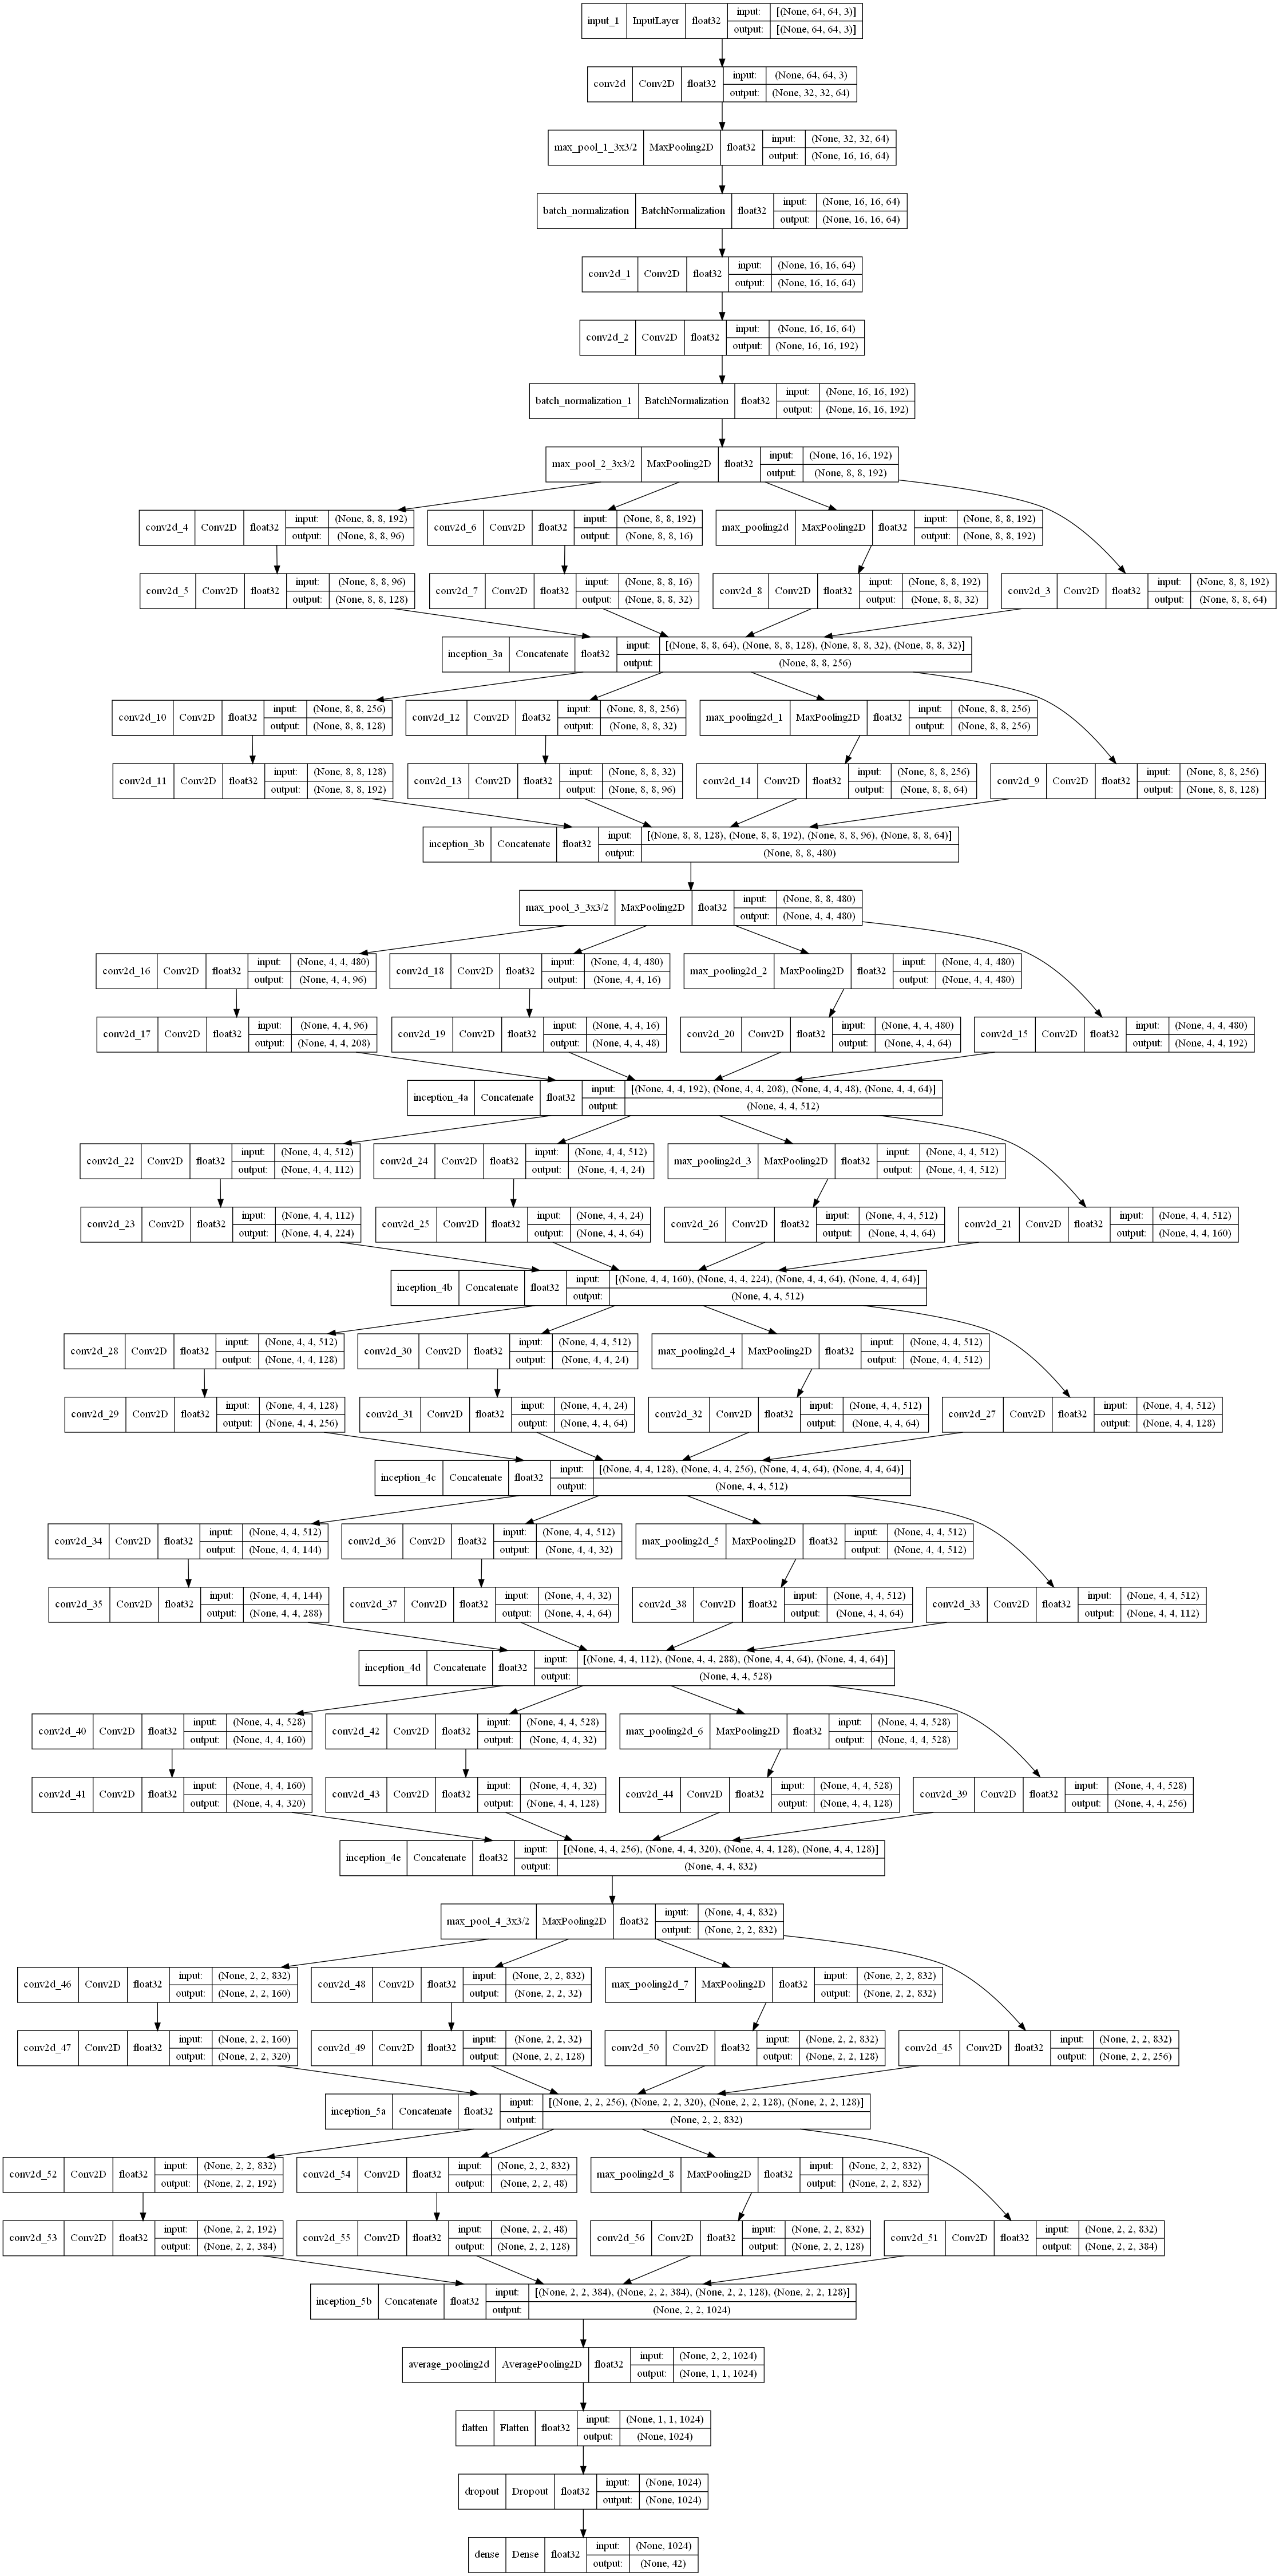

In [3]:
plot_model(model=exp_conv,
           to_file='Inception.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)

In [4]:
tree_types = os.listdir('../../data/image data/train')
X = []
y = []
val_x = []
val_y = []

for tree in tree_types:
    tree_path = os.path.join('../../data/image data/train', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = img_to_array(load_img(image_path, target_size=(64, 64)))
            X.append(image)
            y.append([tree, disease])

for tree in tree_types:
    tree_path = os.path.join('../../data/image data/validation', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = img_to_array(load_img(image_path, target_size=(64, 64)))
            val_x.append(image)
            val_y.append([tree, disease])


In [5]:
X = np.asarray(X)
val_x = np.asarray(val_x)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)
generator = ImageDataGenerator(rescale=1. / 255)

In [6]:
X.shape, y.shape, val_x.shape, val_y.shape

((38104, 64, 64, 3), (38104, 42), (9427, 64, 64, 3), (9427, 42))

In [7]:
train_gen = generator.flow(X, y, batch_size=128)
val_gen = generator.flow(val_x, val_y, batch_size=128)

#### training

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1)

check_point = ModelCheckpoint(filepath='Inception.hdf5',
                              monitor='val_loss',
                              save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=40,
                               restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stopping]

In [9]:
exp_conv.compile(optimizer=Adam(),
                 loss=binary_crossentropy,
                 metrics=['accuracy'])

In [ ]:
exp_conv_history = exp_conv.fit(train_gen,
                                epochs=200,
                                callbacks=callbacks,
                                validation_data=val_gen)

Epoch 1/200
298/298 [==============================] - 116s 351ms/step - loss: 0.1199 - accuracy: 0.2183 - val_loss: 0.2779 - val_accuracy: 0.0548 - lr: 0.0010
Epoch 2/200
298/298 [==============================] - 98s 328ms/step - loss: 0.0553 - accuracy: 0.3547 - val_loss: 0.0795 - val_accuracy: 0.2863 - lr: 0.0010
Epoch 3/200
298/298 [==============================] - 95s 320ms/step - loss: 0.0360 - accuracy: 0.3847 - val_loss: 0.1220 - val_accuracy: 0.2698 - lr: 0.0010
Epoch 4/200
298/298 [==============================] - 100s 335ms/step - loss: 0.0270 - accuracy: 0.4031 - val_loss: 0.0513 - val_accuracy: 0.3507 - lr: 0.0010
Epoch 5/200
298/298 [==============================] - 95s 319ms/step - loss: 0.0228 - accuracy: 0.4238 - val_loss: 0.1202 - val_accuracy: 0.2580 - lr: 0.0010
Epoch 6/200
298/298 [==============================] - 97s 325ms/step - loss: 0.0185 - accuracy: 0.4221 - val_loss: 0.0577 - val_accuracy: 0.3392 - lr: 0.0010
Epoch 7/200
298/298 [=======================

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(exp_conv_history.history['loss'])))

sns.lineplot(x=epochs, y=exp_conv_history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=exp_conv_history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=exp_conv_history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=exp_conv_history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('Inception_train_history.png')
plt.show()